<h1 align="center">PART III</h1>
<h1 align="center">Training and Development of Different LSTM Models</h1> 

To get started, let's download the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import pickle
import gensim, logging
import gensim.models.keyedvectors as word2vec
import matplotlib.pyplot as plt

%matplotlib inline

Also let's write a style for alignment in the middle of all graphs, images, etc:

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h2 align="center">Preparation of input data</h2> 

Firstly, we will load the sample data we processed in the first part:

In [3]:
with open('documents.pql', 'rb') as f:
     docs = pickle.load(f)

In [4]:
print("Number of documents:", len(docs))

Number of documents: 1997


Now we will load our word2vec model. 

This may take some time, as the model contains 325 250  words, so we will get a 325 250 x 300 embedding matrix that contains all the values of the word vectors.

In [5]:
model = word2vec.KeyedVectors.load_word2vec_format('ubercorpus.lowercased.lemmatized.word2vec.300d.txt', binary=False)

Now let's get a list of all the words from our dictionary:

In [6]:
words = list(model.vocab)

Just to make sure everything is loaded correctly, we can look at the dimensions of the dictionary list and the embedding matrix:

In [7]:
print("Total words:", len(words), "\n\nWord-Vectors shape:", model.vectors.shape)

Total words: 325250 

Word-Vectors shape: (325250, 300)


The shape of our sample for training will be `(H, 300, N)`, where:
* `H` - number of samples;
* `300` - dimension of each word; 
* `N` - number of words in each sentence.

Let's analyze how many words are usually found in the reviews:

In [8]:
max_word, min_word = 0, 100
word50, word100, word200, word300, word400  = 0, 0, 0, 0, 0
reviews_len = []

for review, state in docs:
    reviews_len.append(len(review))

    if len(review) > max_word: max_word = len(review)
    if len(review) < min_word: min_word = len(review)

    if len(review) > 50: word50 += 1
    if len(review) > 100: word100 += 1
    if len(review) > 200: word200 += 1
    if len(review) > 300: word300 += 1
    if len(review) > 400: word400 += 1
    
print("Average number of words in the review:", int(sum(reviews_len)/len(reviews_len)))
print("\nMaximum review length:", max_word, "\nMinimum review length:", min_word)
print("\nReview with more than 50 words:", word50, 
      "\nReview with more than 100 words:", word100,
      "\nReview with more than 200 words:", word200, 
      "\nReview with more than 300 words:", word300,
      "\nReview with more than 400 words:", word400)

Average number of words in the review: 71

Maximum review length: 2306 
Minimum review length: 3

Review with more than 50 words: 884 
Review with more than 100 words: 395 
Review with more than 200 words: 115 
Review with more than 300 words: 47 
Review with more than 400 words: 19


Visualize the frequency of words in the review:

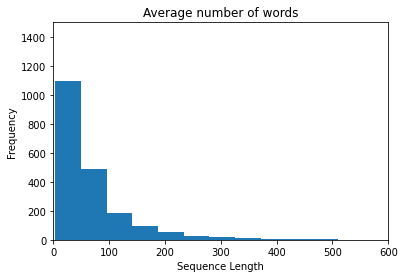

In [9]:
plt.hist(reviews_len, bins=50)
plt.axis([0, 600, 0, 1500])
plt.ylabel('Frequency')
plt.xlabel('Sequence Length');
plt.title("Average number of words");

Our next function `fix_review_len()` will do a useful job, this function is designed to fix the size of reviews to a fixed size to feed them into a neural network with reviews of a certain length. Reviews whose length is less than fixed will be extended by zeros. This process does not affect the algorithm and reviews longer than the specified length will be truncated.

In [10]:
def fix_review_len(review, length):
    if len(review) > length:
        review = review[:length]
    elif len(review) < length:
        for i in range(length - len(review)):
            zeros = [0] * 300
            review.append(zeros)
    return review

example = [3, 1, 2, 4, 5]
example = fix_review_len(example, 7)
print(example) 

[3, 1, 2, 4, 5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Now let's slightly improve our `sent_embed()` function from previous part and then update our dataset with word vectors.

Based on the histogram data, as well as the average number of words in the files, we can say with confidence that most reviews will have less than 100 words, which is the maximum value of the length of the sequence that we set.

In [11]:
def sent_embed(words, docs):
    x_sent_embed, y_sent_embed = [], [] 
    
    max_seq_len = 100
    
    # recover the embedding of each sentence with the average of the vector that composes it
    # sent - sentence, state - state of the sentence (pos/neg)
    for sent, state in docs:
        # average embedding of all words in a sentence
        sent_embed = []
        for word in sent:
            try:
                # if word is present in the dictionary - add its vector representation
                sent_embed.append(model[word])
            except KeyError:
                # if word is not in the dictionary - add a zero vector
                sent_embed.append([0] * 300)
        
        # add a sentence vector to the list
        sent_embed = fix_review_len(sent_embed, max_seq_len)
        x_sent_embed.append(sent_embed)
        
        # add a label to y_sent_embed
        if state == 'pos': y_sent_embed.append(1)
        elif state == 'neg': y_sent_embed.append(0)
            
    return x_sent_embed, y_sent_embed

In [12]:
x, y = sent_embed(words, docs)

In [13]:
x = np.array(x)
print("Shape of X:", x.shape)

Shape of X: (1997, 100, 300)


<h3 align="center">Split Corpus</h3>

Now, for further work, we will divide our corpus for training, testing and development sets:

In [14]:
from sklearn.model_selection import train_test_split

# train test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# train dev
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [15]:
print('Length of x_train:', len(x_train), '| Length of y_train:', len(y_train))
print('Length of x_test:  ', len(x_test), '| Length of y_test: ', len(y_test))
print('Length of x_val:   ', len(x_val), '| Length of y_val:  ', len(y_val))

Length of x_train: 1277 | Length of y_train: 1277
Length of x_test:   400 | Length of y_test:  400
Length of x_val:    320 | Length of y_val:   320


In [16]:
print("Shape of x_train set:", x_train.shape)

Shape of x_train set: (1277, 100, 300)


<h2 align="center">LSTM Model (Batch Size)</h2>

Keras's benefit is that it is built on top of symbolic mathematical libraries such as TensorFlow and Theano for fast and efficient computation. This is needed with large neural networks.

A downside of using these efficient libraries is that you must define the scope of your data upfront and for all time. Specifically, the batch size.

The batch size limits the number of samples to be shown to the network before a weight update can be performed. This same limitation is then imposed when making predictions with the fit model.

Specifically, the batch size used when fitting your model controls how many predictions you must make at a time.

This is often not a problem when you want to make the same number predictions at a time as the batch size used during training.

This does become a problem when you wish to make fewer predictions than the batch size. For example, you may get the best results with a large batch size but are required to make predictions for one observation at a time on something like a time series or sequence problem.

This is why it may be desirable to have a different batch size when fitting the network to training data than when making predictions on test data or new input data.

Batch gradient descent is a variation of the gradient descent algorithm that calculates the error for each example in the training dataset, but only updates the model after all training examples have been evaluated.

<h3 align="center">Setting Up and Creating the Network</h3>

The network has one input, a hidden layer with 100 units, and an output layer with 1 unit.

A mean squared error optimization function is used for this problem with the efficient ADAM optimization algorithm.

So now let's configure and create the network:

In [17]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense
from keras.optimizers import Adam

# configure network
n_neurons = 100
n_epoch = 20
n_batch = 1

# design network
model_batch = Sequential()
model_batch.add(LSTM(n_neurons, input_shape=(x.shape[1], x.shape[2])))
model_batch.add(Dense(1, activation='sigmoid'))
model_batch.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

print(model_batch.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 160,501
Trainable params: 160,501
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
model_batch_hist = model_batch.fit(x_train, np.asarray(y_train), batch_size=n_batch, epochs=n_epoch)

Epoch 1/20
1277/1277 [==============================] - 54s 40ms/step - loss: 0.2576 - binary_accuracy: 0.4814
Epoch 2/20
1277/1277 [==============================] - 51s 40ms/step - loss: 0.2189 - binary_accuracy: 0.6101
Epoch 3/20
1277/1277 [==============================] - 46s 36ms/step - loss: 0.2099 - binary_accuracy: 0.6001
Epoch 4/20
1277/1277 [==============================] - 46s 36ms/step - loss: 0.2076 - binary_accuracy: 0.5972
Epoch 5/20
1277/1277 [==============================] - 46s 36ms/step - loss: 0.2125 - binary_accuracy: 0.5561
Epoch 6/20
1277/1277 [==============================] - 45s 35ms/step - loss: 0.2045 - binary_accuracy: 0.5932
Epoch 7/20
1277/1277 [==============================] - 49s 38ms/step - loss: 0.1981 - binary_accuracy: 0.5929
Epoch 8/20
1277/1277 [==============================] - 56s 44ms/step - loss: 0.2095 - binary_accuracy: 0.6309
Epoch 9/20
1277/1277 [==============================] - 53s 42ms/step - loss: 0.1938 - binary_accuracy: 0.6669
E

In [19]:
score_batch = model_batch.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:",str(round(score_batch[1] * 100, 2)) + '%')

320/320 [==============================] - 4s 9ms/step - loss: 0.2475 - binary_accuracy: 0.6844

Model Accuracy: 68.44%


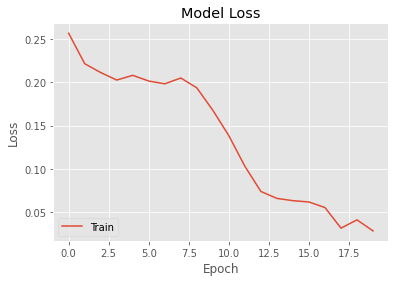

In [20]:
plt.style.use('ggplot')
plt.plot(model_batch_hist.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower left')

plt.show()

The results are not entirely satisfactory, but let's save this model and try a different approach.

In [21]:
from keras.models import load_model

model_batch.save('LSTM-Batch-Model.h5')  # save model
del model_batch  # delete existing model

# returns a compiled model, identical to the previous one
model_batch = load_model('LSTM-Batch-Model.h5')

Let's check if everything is correct:

In [22]:
model_batch.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)

320/320 [==============================] - 4s 9ms/step - loss: 0.2475 - binary_accuracy: 0.6844


[0.24753054976463318, 0.684374988079071]

<h2 align="center">LSTM Model (Mini-Batch Gradient Descent)</h2>

Mini-batch gradient descent is a variation of the gradient descent algorithm that splits the training dataset into small batches that are used to calculate model error and update model coefficients.

Mini batch algorithm is the most favorable and widely used algorithm that makes precise and faster results using a batch of `m` training examples. In mini batch algorithm rather than using  the complete data set, in every iteration we use a set of `m` training examples called batch to compute the gradient of the cost function. Common mini-batch sizes range between 32 and 256.

<h3 align="center">Setting Up and Creating the Network</h3>

We will use an LSTM network fit for 50 epochs and with batch size = 16, cause our dataset is very small.

A mean squared error optimization function is used for this problem with the efficient ADAM optimization algorithm.

`recurrent_dropout`: float between 0 and 1. Fraction of the input units to drop for recurrent connections. 

`dropout`: float between 0 and 1. Fraction of the input units to drop for input gates.


So now let's configure and create the network:

In [23]:
from keras.layers.core import Dropout

# configure network
n_neurons = 100
n_epoch = 50
n_batch = 16

# design network
model_mini = Sequential()
model_mini.add(LSTM(n_neurons, input_shape=(x.shape[1], x.shape[2]), dropout=0.2, recurrent_dropout=0.2))
model_mini.add(Dense(1, activation='sigmoid'))
model_mini.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

print(model_mini.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 160,501
Trainable params: 160,501
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
model_mini_hist = model_mini.fit(x_train, np.asarray(y_train), batch_size=n_batch, epochs=n_epoch)

Epoch 1/50
80/80 [==============================] - 16s 137ms/step - loss: 0.2531 - binary_accuracy: 0.5143
Epoch 2/50
80/80 [==============================] - 11s 133ms/step - loss: 0.2262 - binary_accuracy: 0.6108
Epoch 3/50
80/80 [==============================] - 11s 132ms/step - loss: 0.2175 - binary_accuracy: 0.5926
Epoch 4/50
80/80 [==============================] - 11s 132ms/step - loss: 0.2088 - binary_accuracy: 0.6346
Epoch 5/50
80/80 [==============================] - 11s 131ms/step - loss: 0.2194 - binary_accuracy: 0.5871
Epoch 6/50
80/80 [==============================] - 11s 132ms/step - loss: 0.2144 - binary_accuracy: 0.6172
Epoch 7/50
80/80 [==============================] - 11s 132ms/step - loss: 0.2024 - binary_accuracy: 0.6336
Epoch 8/50
80/80 [==============================] - 11s 142ms/step - loss: 0.2018 - binary_accuracy: 0.6180
Epoch 9/50
80/80 [==============================] - 11s 143ms/step - loss: 0.1994 - binary_accuracy: 0.6283
Epoch 10/50
80/80 [=========

In [25]:
model_mini_score = model_mini.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:",str(round(model_mini_score[1] * 100, 2)) + '%')

20/20 [==============================] - 1s 29ms/step - loss: 0.2107 - binary_accuracy: 0.7031

Model Accuracy: 70.31%


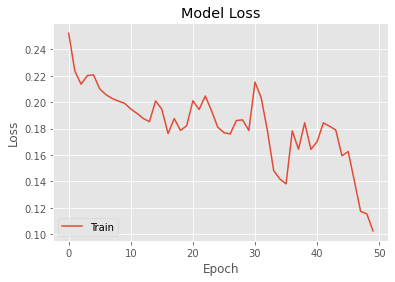

In [26]:
plt.plot(model_mini_hist.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower left')

plt.show()

This is a good value for the model, we can use it. Let's save our model:

In [27]:
model_mini.save('LSTM-Mini-Batch-Model.h5')  # save model
del model_mini  # delete existing model

# returns a compiled model, identical to the previous one
model_mini = load_model('LSTM-Mini-Batch-Model.h5')

Let's check if everything is correct:

In [28]:
model_mini.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)

20/20 [==============================] - 1s 27ms/step - loss: 0.2107 - binary_accuracy: 0.7031


[0.21070384979248047, 0.703125]

<h2 align="center">Stacked LSTM Layers</h2>

Now we will try the model with a 3 stacked LSTM layers:

In [73]:
# configure network
n_neurons = 100
n_epoch = 20
n_batch = 64

# design network
model3L = Sequential()

model3L.add(LSTM(n_neurons, return_sequences=True, input_shape=(x.shape[1], x.shape[2])))
model3L.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model3L.add(LSTM(32))  # return a single vector of dimension 32

model3L.add(Dense(1, activation='sigmoid'))
model3L.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

print(model3L.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100, 100)          160400    
_________________________________________________________________
lstm_14 (LSTM)               (None, 100, 32)           17024     
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 185,777
Trainable params: 185,777
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
model3L_hist = model3L.fit(x_train, np.asarray(y_train), batch_size=n_batch, epochs=n_epoch)

Epoch 1/20
20/20 [==============================] - 17s 282ms/step - loss: 0.2495 - binary_accuracy: 0.5182
Epoch 2/20
20/20 [==============================] - 6s 287ms/step - loss: 0.2373 - binary_accuracy: 0.5868
Epoch 3/20
20/20 [==============================] - 6s 276ms/step - loss: 0.1735 - binary_accuracy: 0.7521
Epoch 4/20
20/20 [==============================] - 6s 285ms/step - loss: 0.1084 - binary_accuracy: 0.8725
Epoch 5/20
20/20 [==============================] - 6s 281ms/step - loss: 0.0955 - binary_accuracy: 0.8833
Epoch 6/20
20/20 [==============================] - 6s 276ms/step - loss: 0.1350 - binary_accuracy: 0.8369
Epoch 7/20
20/20 [==============================] - 6s 275ms/step - loss: 0.1137 - binary_accuracy: 0.8719
Epoch 8/20
20/20 [==============================] - 6s 277ms/step - loss: 0.1142 - binary_accuracy: 0.8590
Epoch 9/20
20/20 [==============================] - 6s 279ms/step - loss: 0.0923 - binary_accuracy: 0.8862
Epoch 10/20
20/20 [=================

In [75]:
model3L_score = model3L.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:",str(round(model3L_score[1] * 100, 2)) + '%')

5/5 [==============================] - 3s 134ms/step - loss: 0.2271 - binary_accuracy: 0.7344

Model Accuracy: 73.44%


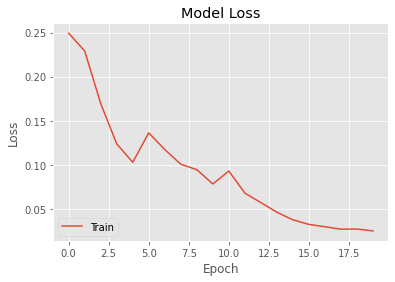

In [76]:
plt.plot(model3L_hist.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower left')

plt.show()

Let's save our model:

In [77]:
model3L.save('LSTM-3L-Model.h5')  # save model
del model3L  # delete existing model

# returns a compiled model, identical to the previous one
model3L = load_model('LSTM-3L-Model.h5')

Let's check if everything is correct:

In [78]:
model3L.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)

5/5 [==============================] - 3s 122ms/step - loss: 0.2271 - binary_accuracy: 0.7344


[0.2270735800266266, 0.734375]

<h2 align="center">CNN + LSTM</h2>

This approach is based entirely on [this work](https://www.aclweb.org/anthology/P16-2037.pdf). As indicated in the work:

<cite>
    
    Dimensional sentiment analysis aims to recognize continuous numerical values in multiple dimensions such as the valencearousal (VA) space. 
    
    Compared to the categorical approach that focuses on sentiment classification such as binary classification (i.e., positive and negative), the dimensional approach can provide more fine-grained sentiment analysis. This study proposes a regional CNN-LSTM model consisting of two parts: regional CNN and LSTM to predict the VA ratings of texts. 
   
    Unlike a conventional CNN which considers a whole text as input, the proposed regional CNN uses an individual sentence as a region, dividing an input text into several regions such that the useful affective information in each region can be extracted and weighted according to their contribution to the VA prediction. Such regional information is sequentially integrated across regions using LSTM for VA prediction. 

</cite>

In short, word vectors of vocabulary words are trained from a large corpus using the word2vec toolkit. For each given text, the  regional CNN model uses the sentence as a region to divide the text into R-domains, ie r1, ..., ri rj, rk, ..., rR. In each region, useful affective functions can be removed when word vectors pass sequentially through the convolutional layer and the  maxpooling  layer. Then such local (regional) features are sequentially integrated between regions using LSTM to construct a text vector for VA prediction.

In [83]:
from keras.layers import Conv1D, MaxPooling1D

# configure network
n_epoch = 20
n_batch = 16

# design network
model_CNN_LSTM = Sequential()

model_CNN_LSTM.add(Conv1D(filters=100, kernel_size=3, input_shape=(x.shape[1], x.shape[2]), padding='same', activation='relu'))
model_CNN_LSTM.add(MaxPooling1D(pool_size=2))
model_CNN_LSTM.add(LSTM(100))
model_CNN_LSTM.add(Dense(1, activation='sigmoid'))

model_CNN_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_CNN_LSTM.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 100, 100)          90100     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 100)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 170,601
Trainable params: 170,601
Non-trainable params: 0
_________________________________________________________________
None


In [84]:
model_CNN_LSTM_hist = model_CNN_LSTM.fit(x_train, np.asarray(y_train), epochs=n_epoch, batch_size=n_batch)

Epoch 1/20
80/80 [==============================] - 10s 61ms/step - loss: 0.6954 - accuracy: 0.5319
Epoch 2/20
80/80 [==============================] - 5s 62ms/step - loss: 0.6370 - accuracy: 0.6022
Epoch 3/20
80/80 [==============================] - 5s 60ms/step - loss: 0.5699 - accuracy: 0.5746
Epoch 4/20
80/80 [==============================] - 5s 60ms/step - loss: 0.5542 - accuracy: 0.6189
Epoch 5/20
80/80 [==============================] - 5s 59ms/step - loss: 0.5546 - accuracy: 0.7067
Epoch 6/20
80/80 [==============================] - 5s 59ms/step - loss: 0.4753 - accuracy: 0.7802 0s - loss: 0.4775 - 
Epoch 7/20
80/80 [==============================] - 5s 61ms/step - loss: 0.4002 - accuracy: 0.8230
Epoch 8/20
80/80 [==============================] - 5s 67ms/step - loss: 0.3523 - accuracy: 0.8599
Epoch 9/20
80/80 [==============================] - 5s 65ms/step - loss: 0.2332 - accuracy: 0.9230
Epoch 10/20
80/80 [==============================] - 5s 62ms/step - loss: 0.2405 - accu

In [85]:
model_CNN_LSTM_score = model_CNN_LSTM.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:",str(round(model_CNN_LSTM_score[1] * 100, 2)) + '%')

20/20 [==============================] - 1s 21ms/step - loss: 0.8084 - accuracy: 0.7375

Model Accuracy: 73.75%


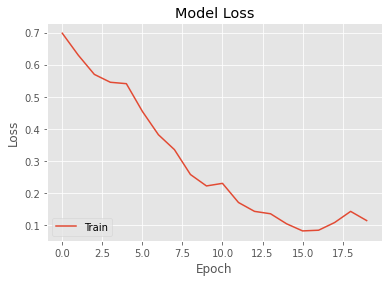

In [86]:
plt.plot(model_CNN_LSTM_hist.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower left')

plt.show()

Let's save our model:

In [87]:
model_CNN_LSTM.save('LSTM-CNN-Model.h5')  # save model
del model_CNN_LSTM  # delete existing model

# returns a compiled model, identical to the previous one
model_CNN_LSTM = load_model('LSTM-CNN-Model.h5')

<h3 align="center">Testing</h3>

Let's try to check the test data with all but one of the test examples to see if the model can predict it:

In [88]:
print("Length of test data (except 1):", len(x_test[:-1]))

Length of test data (except 1): 399


In [89]:
score_test = model_CNN_LSTM.evaluate(x_test[:-1], np.asarray(y_test[:-1]))
print(score_test)

13/13 [==============================] - 1s 27ms/step - loss: 0.7839 - accuracy: 0.7268
[0.783936619758606, 0.7268170714378357]


In [90]:
score_test_one = model_CNN_LSTM.evaluate(x_test[-1:], np.asarray(y_test[-1:]))
print(score_test_one)

1/1 [==============================] - 0s 32ms/step - loss: 0.1716 - accuracy: 1.0000
[0.17160160839557648, 1.0]


In [93]:
predict_test = model_CNN_LSTM.predict_classes(x_test[:-1])
print(predict_test)

[[1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]


In [94]:
predict_test_one = model_CNN_LSTM.predict_classes(x_test[-1:])

In [95]:
print("Predicted value:", predict_test_one[0][0], "\nActual value:", y_test[-1:][0])

Predicted value: 1 
Actual value: 1


Prediction works great, now let's visualize the data.

<h2 align="center">Visualization of Classification Report</h2>

We will need our method from previous part to visualize our data, so we will use them now.

In [96]:
def plot_classification_report(classification_report, title='Classification Report', cmap='RdBu'):
    
    lines = classification_report.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    
    for line in lines[2 : (len(lines) - 5)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

In [97]:
def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC, edgecolors='k', linestyle='dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # add color bar
    plt.colorbar(c)

    # add text in each cell 
    show_val(c)

    # proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm_to_inch(figure_width, figure_height))

In [98]:
def show_val(pc, fmt="%.2f", **kw):
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

In [99]:
def cm_to_inch(*dim):
    inch = 2.54
    return tuple(i/inch for i in dim[0]) if type(dim[0]) == tuple else tuple(i/inch for i in dim)

<h2 align="center">Comparison of Models</h2> 

A useful tool when predicting the probability of a binary outcome is the Receiver Operating Characteristic curve, or ROC curve.

It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. Put another way, it plots the false alarm rate versus the hit rate.

The true positive rate is calculated as the number of true positives divided by the sum of the number of true positives and the number of false negatives. It describes how good the model is at predicting the positive class when the actual outcome is positive.

The false positive rate is calculated as the number of false positives divided by the sum of the number of false positives and the number of true negatives.

It is also called the false alarm rate as it summarizes how often a positive class is predicted when the actual outcome is negative.

To make this clear:
* Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
* Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

Classification Report LSTM Batch Model:
               precision    recall  f1-score   support

           0       0.64      0.63      0.64       199
           1       0.64      0.66      0.65       201

    accuracy                           0.64       400
   macro avg       0.64      0.64      0.64       400
weighted avg       0.64      0.64      0.64       400



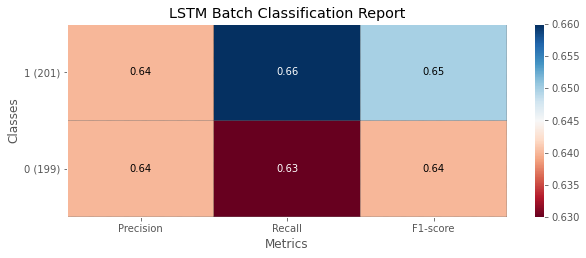

In [100]:
from sklearn.metrics import classification_report

batch_prediction = (model_batch.predict(x_test) > 0.5).astype("int32")
print('Classification Report LSTM Batch Model:\n', classification_report(y_test, batch_prediction))

plot_classification_report(classification_report(y_test, batch_prediction), title='LSTM Batch Classification Report', cmap='RdBu')

Classification Report LSTM Mini-Batch Model:
               precision    recall  f1-score   support

           0       0.71      0.67      0.69       199
           1       0.69      0.73      0.71       201

    accuracy                           0.70       400
   macro avg       0.70      0.70      0.70       400
weighted avg       0.70      0.70      0.70       400



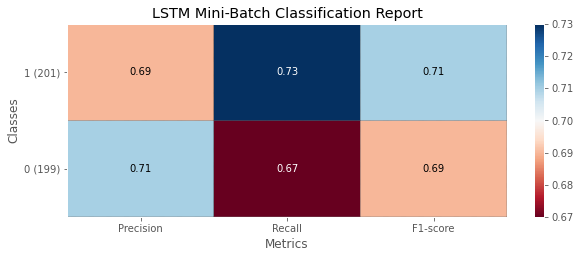

In [101]:
mini_prediction = (model_mini.predict(x_test) > 0.5).astype("int32")
print('Classification Report LSTM Mini-Batch Model:\n', classification_report(y_test, mini_prediction))

plot_classification_report(classification_report(y_test, mini_prediction), title='LSTM Mini-Batch Classification Report', cmap='RdBu')

Classification Report LSTM Stacked Layers Model:
               precision    recall  f1-score   support

           0       0.70      0.68      0.69       199
           1       0.69      0.71      0.70       201

    accuracy                           0.69       400
   macro avg       0.70      0.69      0.69       400
weighted avg       0.70      0.69      0.69       400



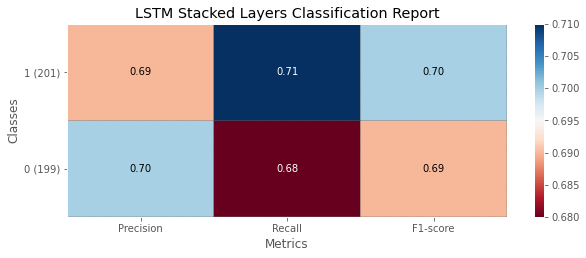

In [102]:
stack_layer_prediction = (model3L.predict(x_test) > 0.5).astype("int32")
print('Classification Report LSTM Stacked Layers Model:\n', classification_report(y_test, stack_layer_prediction))

plot_classification_report(classification_report(y_test, stack_layer_prediction), title='LSTM Stacked Layers Classification Report', cmap='RdBu')

Classification Report CNN + LSTM Model:
               precision    recall  f1-score   support

           0       0.74      0.70      0.72       199
           1       0.72      0.76      0.74       201

    accuracy                           0.73       400
   macro avg       0.73      0.73      0.73       400
weighted avg       0.73      0.73      0.73       400



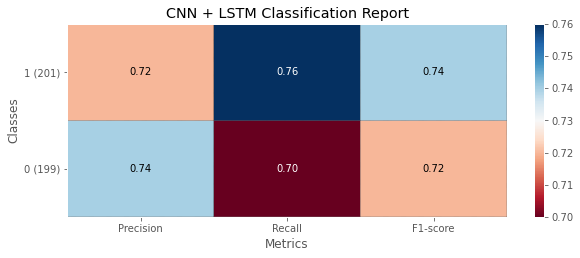

In [103]:
lstm_cnn_prediction = (model_CNN_LSTM.predict(x_test) > 0.5).astype("int32")
print('Classification Report CNN + LSTM Model:\n', classification_report(y_test, lstm_cnn_prediction))

plot_classification_report(classification_report(y_test, lstm_cnn_prediction), title='CNN + LSTM Classification Report', cmap='RdBu')

In [104]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

fprB, tprB, thresholdsB = metrics.roc_curve(y_test, model_batch.predict(x_test))
fprMB, tprMB, thresholdsMB = metrics.roc_curve(y_test, model_mini.predict(x_test))
fpr3L, tpr3L, thresholds3L = metrics.roc_curve(y_test, model3L.predict(x_test))
fprCNN, tprCNN, thresholdsCNN = metrics.roc_curve(y_test, model_CNN_LSTM.predict(x_test))

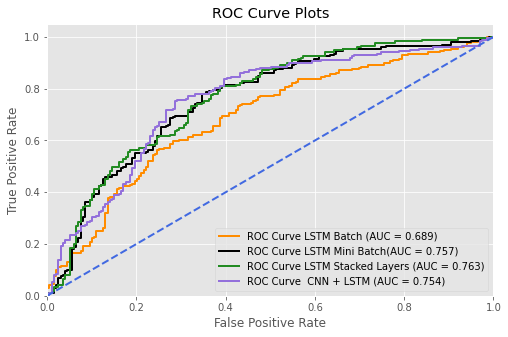

In [105]:
linewidth = 2
plt.figure(figsize=(8, 5))

plt.plot(fprB, tprB, color='darkorange', lw=linewidth, label='ROC Curve LSTM Batch (AUC = %0.3f)' % auc(fprB, tprB))
plt.plot(fprMB, tprMB, color='black', lw=linewidth, label='ROC Curve LSTM Mini Batch(AUC = %0.3f)' % auc(fprMB, tprMB))
plt.plot(fpr3L, tpr3L, color='forestgreen', lw=linewidth, label='ROC Curve LSTM Stacked Layers (AUC = %0.3f)' % auc(fpr3L, tpr3L))
plt.plot(fprCNN, tprCNN, color='mediumpurple', lw=linewidth, label='ROC Curve  CNN + LSTM (AUC = %0.3f)' % auc(fprCNN, tprCNN))
plt.plot([0, 1], [0, 1], color='royalblue', lw=linewidth, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Plots')
plt.legend(loc="lower right")

plt.show()

As we can see, all models show approximately the same result, but so far the best is the model with 3 layers, although during testing I saw that the most stable model is Mini-Batch and CNN + LSTM. Here we are finished, then we move on to the development of a web application, when creating it, I prefer the model CNN + LSTM, and then we will experiment.